# Task

Operators like joins, selections and missing value imputaters can cause *data distribution issues*, which can heavily impact the performance of our model for specific demographic groups. Mlinspect helps with identifying such issues by offering a check that calculates histograms for sensitive groups in the data and verifying whether the histogram change is significant enough to alert the user. Thanks to our annotation propagation, we can deal with complex code involving things like nested sklearn pipelines and group memberships that are removed from the training data using projections.

We want to find out if preprocessing operations in pipelines introduce bias and if so, which groups are effected.
The pipeline we want to analyse in this task can be found using the path `os.path.join(str(get_project_root()), "experiments", "user_interviews", "compas_modified.py")`. The senstive attributes we want to take a look at are `sex` and `race`. 

The COMPAS dataset contains information about 6,889 criminal defendants in Broward County, FL, along with predictions of their recidivism risk, as produced by a commercial tool called COMPAS. The sensitive attributes include gender and race. The task is to predict whether a defendant is likely re-offend. We took this existing data set and only modified it slightly by introducing an artificial issue which we will now try to find using mlinspect.

The code of the pipeline:

> ```python
> """
> COMPAS pipeline
> """
> import os
> 
> import pandas as pd
> from sklearn.compose import ColumnTransformer
> from sklearn.impute import SimpleImputer
> from sklearn.linear_model import LogisticRegression
> from sklearn.pipeline import Pipeline
> from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, label_binarize
> 
> from mlinspect.utils import get_project_root
> 
> train_file = os.path.join(str(get_project_root()), "experiments", "user_interviews", "compas_train_modified.csv")
> train = pd.read_csv(train_file, na_values='?', index_col=0)
> test_file = os.path.join(str(get_project_root()), "example_pipelines", "compas", "compas_test.csv")
> test = pd.read_csv(test_file, na_values='?', index_col=0)
> 
> train = train[
>     ['sex', 'dob', 'age', 'c_charge_degree', 'race', 'score_text', 'priors_count', 'days_b_screening_arrest',
>      'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
> test = test[
>     ['sex', 'dob', 'age', 'c_charge_degree', 'race', 'score_text', 'priors_count', 'days_b_screening_arrest',
>      'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
> 
> # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested,
> # we assume that because of data quality reasons, that we do not have the right offense.
> train = train[(train['days_b_screening_arrest'] <= 30) & (train['days_b_screening_arrest'] >= -30)]
> # We coded the recidivist flag – is_recid – to be -1 if we could not find a compas case at all.
> train = train[train['is_recid'] != -1]
> # In a similar vein, ordinary traffic offenses – those with a c_charge_degree of ‘O’ – will not result in Jail
> # time are removed (only two of them).
> train = train[train['c_charge_degree'] != "O"]
> # We filtered the underlying data from Broward county to include only those rows representing people who had either
> # recidivated in two years, or had at least two years outside of a correctional facility.
> train = train[train['score_text'] != 'N/A']
> 
> train = train.replace('Medium', "Low")
> test = test.replace('Medium', "Low")
> 
> train_labels = label_binarize(train['score_text'], classes=['High', 'Low'])
> test_labels = label_binarize(test['score_text'], classes=['High', 'Low'])
> 
> impute_and_onehot = Pipeline([('imputer1', SimpleImputer(strategy='most_frequent')),
>                               ('onehot', OneHotEncoder(handle_unknown='ignore'))])
> impute_and_bin = Pipeline([('imputer2', SimpleImputer(strategy='mean')),
>                            ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform'))])
> 
> compas_featurizer = ColumnTransformer(transformers=[
>     ('impute1_and_onehot', impute_and_onehot, ['is_recid']),
>     ('impute2_and_bin', impute_and_bin, ['age'])
> ])
> compas_pipeline = Pipeline([
>     ('features', compas_featurizer),
>     ('classifier', LogisticRegression())
> ])
> 
> compas_pipeline.fit(train, train_labels.ravel())
> print(compas_pipeline.score(test, test_labels.ravel()))
> ```

# Step 1/4: Add check and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `.py` file. 

First, we define the check we want mlinspect to run. In this example, we only use `NoBiasIntroducedFor(["col1", "col2", ...])` to automatically check for significant changes in the distribution of sensitive demograhpic groups and compute the histograms.

Then, we execute the pipeline. Mlinspect returns a `InspectorResult`, which, among other information, contains the output of our check. 

In [1]:
import os
from mlinspect.utils import get_project_root

from mlinspect import PipelineInspector
from mlinspect.checks import NoBiasIntroducedFor

COMPAS_FILE_PY = os.path.join(str(get_project_root()), "experiments", "user_interviews", "compas_modified.py")

inspector_result = PipelineInspector\
    .on_pipeline_from_py_file(COMPAS_FILE_PY) \
    .add_check(NoBiasIntroducedFor(['sex', 'race'])) \
    .execute()

check_results = inspector_result.check_to_check_results

0.8078521939953811


# Step 2/4: Overview of the check results
## Did our check find issues?

Let us look at the `check_result` to see our some check failed. We do this using the mlinspect utlity function `check_results_as_data_frame(...)`. We see that an issue was found, so we have to investigate it.

In [2]:
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

check_result_df = PipelineInspector.check_results_as_data_frame(check_results)
display(check_result_df)

,check_name,status,description
0,"NoBiasIntroducedFor((('sex', 'race'), -0.3))",CheckStatus.FAILURE,"A Selection causes a min_relative_ratio_change of 'race' by -0.33167874516032964, a value below the configured minimum threshold -0.3! A Selection causes a min_relative_ratio_change of 'race' by -0.4770364294546038, a value below the configured minimum threshold -0.3!"


# Step 3/4: List of operations that could change the distribution 

As stated before, only some operations like selections, joins and missing value imputation can change the distribution. Our check already filtered all operators that can cause data distribution issues. We can use the mlinspect utility function `get_distribution_changes_overview_as_df(...)` to get an overview. The overview already tells us that mlinspect detected potential issues caused by the first two selections. Note that the automatic issue detection from mlinspect is only as good as its configuration and should not be completely relied upon.

In [3]:
no_bias_check_result = check_results[NoBiasIntroducedFor(['sex', 'race'])]

distribution_changes_overview_df = NoBiasIntroducedFor.get_distribution_changes_overview_as_df(no_bias_check_result)
display(distribution_changes_overview_df)

dag_node_distribution_changes_list = list(no_bias_check_result.bias_distribution_change.items())

,operator_type,description,code_reference,source_code,module,'sex' distribution change below the configured minimum test threshold,'race' distribution change below the configured minimum test threshold
0,OperatorType.SELECTION,Select by Series: train[(train['days_b_screening_arrest'] <= 30) & (train['days_b_screening_arrest'] >= -30)],"CodeReference(lineno=29, col_offset=8, end_lineno=29, end_col_offset=99)",train[(train['days_b_screening_arrest'] <= 30) & (train['days_b_screening_arrest'] >= -30)],"FunctionInfo(module='pandas.core.frame', function_name='__getitem__')",False,True
1,OperatorType.SELECTION,Select by Series: train[train['is_recid'] != -1],"CodeReference(lineno=31, col_offset=8, end_lineno=31, end_col_offset=38)",train[train['is_recid'] != -1],"FunctionInfo(module='pandas.core.frame', function_name='__getitem__')",False,True
2,OperatorType.SELECTION,"Select by Series: train[train['c_charge_degree'] != ""O""]","CodeReference(lineno=34, col_offset=8, end_lineno=34, end_col_offset=46)","train[train['c_charge_degree'] != ""O""]","FunctionInfo(module='pandas.core.frame', function_name='__getitem__')",False,False
3,OperatorType.SELECTION,Select by Series: train[train['score_text'] != 'N/A'],"CodeReference(lineno=37, col_offset=8, end_lineno=37, end_col_offset=43)",train[train['score_text'] != 'N/A'],"FunctionInfo(module='pandas.core.frame', function_name='__getitem__')",False,False


# Step 4/4 Detailed Investigation

Now that we know of potential issues, we will take a look at the histograms before and after the JOIN. We can use `distribution_change.before_and_after_df` to look at the data in form of a `pandas.DataFrame` or use the mlinspect utility function `plot_distribution_change_histograms(...)` to plot the histograms. 

OperatorType.SELECTION: train[(train['days_b_screening_arrest'] <= 30) & (train['days_b_screening_arrest'] >= -30)]

 Column 'sex', acceptable change: True, min_relative_ratio_change: -0.00526926631466584


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,Female,970,825,0.192117,0.191105,-0.005269
1,Male,4079,3492,0.807883,0.808895,0.001253


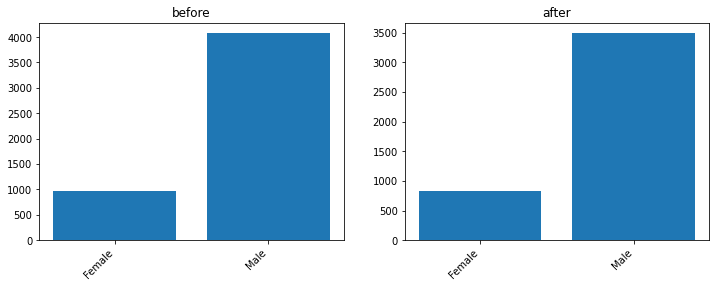


 Column 'race', acceptable change: False, min_relative_ratio_change: -0.33167874516032964


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,African-American,2588,2228,0.512577,0.516099,0.006872
1,Asian,23,22,0.004555,0.005096,0.118712
2,Caucasian,1707,1462,0.338087,0.338661,0.001699
3,Hispanic,452,357,0.089523,0.082696,-0.076253
4,Native American,14,8,0.002773,0.001853,-0.331679
5,Other,265,240,0.052486,0.055594,0.059226


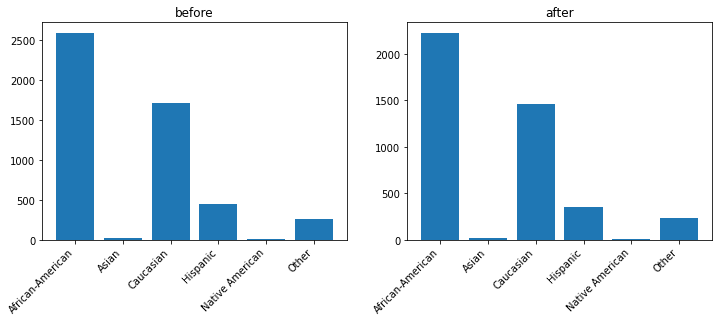

In [4]:
# Select the DagNode we want to look at by index
dag_node, node_distribution_changes = dag_node_distribution_changes_list[0]

# Investige the changes
print("\033[1m{}: {}\033[0m".format(dag_node.operator_info.operator, dag_node.optional_code_info.source_code))
for column, distribution_change in node_distribution_changes.items():
    print("")
    print("\033[1m Column '{}'\033[0m, acceptable change: {}, min_relative_ratio_change: {}".format(column, distribution_change.acceptable_change, distribution_change.min_relative_ratio_change))
    display(distribution_change.before_and_after_df)
    NoBiasIntroducedFor.plot_distribution_change_histograms(distribution_change)

OperatorType.SELECTION: train[train['is_recid'] != -1]

 Column 'sex', acceptable change: True, min_relative_ratio_change: -0.0029918244774166398


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,Female,825,801,0.191105,0.193525,0.012664
1,Male,3492,3338,0.808895,0.806475,-0.002992


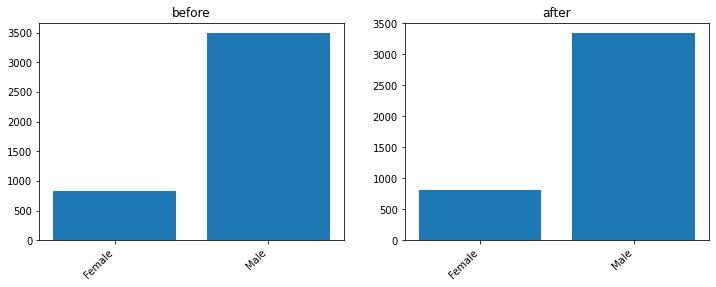


 Column 'race', acceptable change: False, min_relative_ratio_change: -0.4770364294546038


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,African-American,2228,2228,0.516099,0.538294,0.043006
1,Asian,22,22,0.005096,0.005315,0.043006
2,Caucasian,1462,1462,0.338661,0.353225,0.043006
3,Hispanic,357,179,0.082696,0.043247,-0.477036
4,Native American,8,8,0.001853,0.001933,0.043006
5,Other,240,240,0.055594,0.057985,0.043006


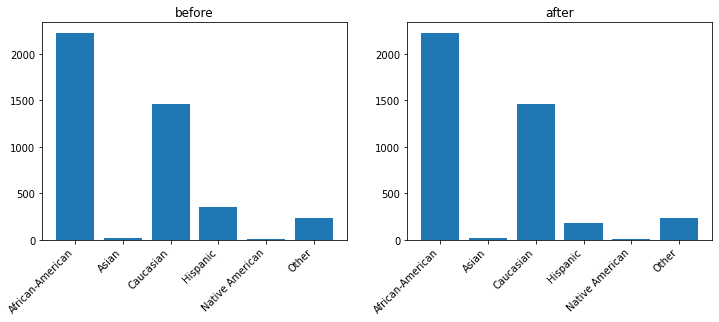

In [5]:
# Select the DagNode we want to look at by index
dag_node, node_distribution_changes = dag_node_distribution_changes_list[1]

# Investige the changes
print("\033[1m{}: {}\033[0m".format(dag_node.operator_info.operator, dag_node.optional_code_info.source_code))
for column, distribution_change in node_distribution_changes.items():
    print("")
    print("\033[1m Column '{}'\033[0m, acceptable change: {}, min_relative_ratio_change: {}".format(column, distribution_change.acceptable_change, distribution_change.min_relative_ratio_change))
    display(distribution_change.before_and_after_df)
    NoBiasIntroducedFor.plot_distribution_change_histograms(distribution_change)

# Your answer: Did we find operators that introduce bias? How did the distribution of demographic groups change?

**My anser:** The first selection filters out 6 out of 14 data points with `race=Native American`. Although the plotted histogram makes it barely noticable, more than 30% of these data points are filtered out, which could be a problem for the final model performance for this demographic group. A lot more noticable, the second selection filters out more than 47% of the data points with `race=Hispanic`, which are 187 data points. This is something we definitely need to consider.